This one has been on the back burner for quite a while. When Pat Lorton was working on the initial version of [gpusimilarity](https://github.com/schrodinger/gpusimilarity) and his presentation for the [2018 RDKit UGM](https://github.com/schrodinger/gpusimilarity/blob/master/gpusimilarity_rdkit_presentation.pdf) he dealt with the limited amount of memory available on GPUs by loading highly folded fingerprints into the GPU, retrieving extra compounds for a TopN query, and then rescoring those compounds using full-sized fingerprints. I wanted to go back and look at the same problem again from the perspective of a threshold similarity query - i.e. "give me all of the results that have a similarity above my threshold" - instead of the TopN query - i.e. "give me the N nearest neighbors in the database" - Pat was looking at.

This blog post starts that. I'm not going to take a more general approach and look at the impact of fingerprint size on search results and performance at various threshold levels. I'm not going to actually use gpusimilarity in this particular post, but hopefully I will get to that in the future.

This post ended up being longer than I thought it was going to be... here's an overview of the pieces:

- Look at the impact of folding on computed similarity values.  [link](#Impact-of-fingerprint-size-on-computed-similarity)
- Look at the impact of folding on the number of results returned by a similarity search. [link](#Comparing-the-the-number-of-neighbors-retrieved)
- How many hits do we miss by folding the fingerprints? [link](#How-many-hits-do-we-miss?)
- How many extra hits do we retrieve when folding the fingerprints? [link](#Efficiency,-look-at-the-number-of-extra-hits)
- Performance: what impact does fingerprint size have on search times in PostgreSQL? [link](#In-PostgreSQL)
- Performance: what impact does fingerprint size have on search times using [FPSim2](https://github.com/chembl/FPSim2)? [link](#Using-FPSim2)

The TL;DR summary: When working with the RDKit's Morgan2 fingerprint (MFP2), I think it's reasonable to fold the fingerprints down to 128 bits, particularly when using higher similarity thresholds. This balances the number of hits missed against the number of extra hits retrieved and can result in significant performance improvements when using a specialized search tool like [FPSim2](https://github.com/chembl/FPSim2). The smaller fingerprints - 128 bit fingerprints are 1/16th the size of 2048 bit fingerprints - are faster to read from storage and allow us to fit considerably more fingerprints in the same amount of memory, which is particularly helpful with GPUs.

In [1]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import RDLogger
from rdkit import rdBase
from rdkit import DataStructs
import pickle
import time
import gzip
print(rdBase.rdkitVersion)
print(time.asctime())
%pylab inline
plt.style.use('tableau-colorblind10')


2022.09.5
Fri Mar 24 06:17:55 2023
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Impact of fingerprint size on computed similarity

Start by looking at the impact of increased fingerprint folding - decreasing fingerprint size - on similarity values.

For this I use the [similarity comparison set](https://rdkit.blogspot.com/2016/04/revisiting-similarity-comparison-set.html) that I put together a few years ago. I'm more interested in the impact on molecules that have a reasonable similiarty to each other, so I'm using the set of pairs that have tanimoto similarity of at least 0.6 with the Morgan1 fingerprint. 

Generate the similarity values for multiple bit counts:

In [2]:
rows=[]
for row in gzip.open('../data/chembl30_50K.mfp1.pairs.txt.gz').readlines():
    row = row.split(b'\t')
    row[1] = Chem.MolFromSmiles(row[1])
    row[3] = Chem.MolFromSmiles(row[3])
    rows.append(row)

In [3]:
from collections import defaultdict

sims = defaultdict(list)
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2)
fpgs = {}
for bitsize in (64, 128, 256, 512,1024,2048,4096):
    fpgs[bitsize]  = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=bitsize)
for i,row in enumerate(rows):
    m1 = row[1]
    m2 = row[3]
    fp1 = fpg.GetSparseCountFingerprint(m1)
    fp2 = fpg.GetSparseCountFingerprint(m2)
    sims[-1].append(DataStructs.TanimotoSimilarity(fp1,fp2))
    
    for bitsize in (64, 128, 256, 512,1024,2048,4096):
        fp1 = fpgs[bitsize].GetFingerprint(m1)
        fp2 = fpgs[bitsize].GetFingerprint(m2)
        sims[bitsize].append(DataStructs.TanimotoSimilarity(fp1,fp2))
    if not (i+1)%5000: print("Done:",i+1)

Done: 5000
Done: 10000
Done: 15000
Done: 20000
Done: 25000
Done: 30000
Done: 35000
Done: 40000
Done: 45000
Done: 50000


And then plot histograms to show how much the similarity changes relatively to the 4096 bit fingerprint for the different bit counts. 

Positive values indicate that the folded fingerprint yields a higher similarity

I include the histogram twice: once with a linear y axis and once with a log y axis so that the behavior at the edges is more visible.

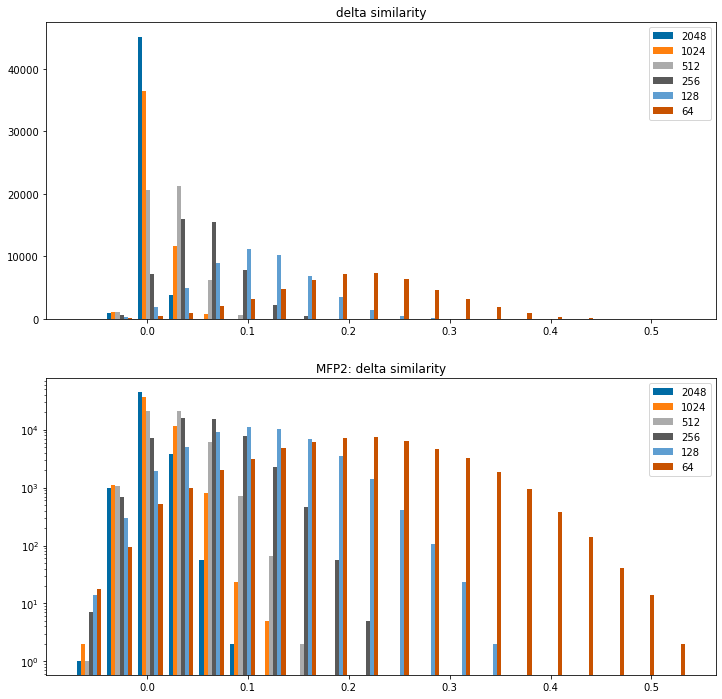

In [4]:
figsize(12,12)
bcounts = (2048,1024,512,256,128,64)

diffs = []
for bcount in bcounts:
    diffs.append(np.array(sims[bcount])-np.array(sims[4096]))
subplot(2,1,1)
hist(diffs,label=[str(x) for x in bcounts],bins=20);
legend();
title('delta similarity');
subplot(2,1,2)
hist(diffs,label=[str(x) for x in bcounts],bins=20,log=True);
legend();
title('MFP2: delta similarity');

Clear (and generally unsurprising) conclusion from this: folding the fingerprints tends to increase computed similarity values. Going all the way down to 64bits does so dramatically.

It's also worth looking at how much the folding changes the ranking of similarities. This is where I may get into trouble with people who are better at stats than I am, but I think the right metric for this is [Spearman's rank correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient):

In [5]:
from scipy import stats
bcounts = (2048,1024,512,256,128,64)
for bcount in bcounts:
    r,p = stats.spearmanr(sims[bcount],sims[4096])
    print(f"{bcount} bits: r={r:.3f} p={p:.3g}")

2048 bits: r=0.997 p=0
1024 bits: r=0.992 p=0
512 bits: r=0.982 p=0
256 bits: r=0.957 p=0
128 bits: r=0.900 p=0
64 bits: r=0.775 p=0


It's nice to see how high these are, particularly 128 bits. Even the super-short 64 bit fingerprints maintain the ranking of these pairs reasonably well.

In the [original version](http://rdkit.blogspot.com/2020/08/doing-similarity-searches-with-highly.html) of this post I showed that their higher bit density causes the performance of the RDKit fingerprint degrades much more quickly as the fingerprints get short. I won't revisit that here.


# Impact on similarity searching

Let's move on to looking at the impact shorter fingerprints have on similarity searching, specifically the number of results retrieved for queries using different similarity cutoffs.

Our test database for this is the SDF from ChEMBL32. I downloaded this directly from the [ChEMBL website](ftp://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/). It's also possible to do this automatically using Charles Hoyt's [ChEMBL Downloader](https://github.com/cthoyt/chembl-downloader)

Read in that SDF and generate MFP2 fingerprints:

In [6]:
import pickle, time, gzip

gz = gzip.GzipFile('/home/glandrum/Downloads/chembl_32.sdf.gz')
suppl = Chem.ForwardSDMolSupplier(gz)

RDLogger.DisableLog("rdApp.warning")
t1=time.time()
data = []

fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=4096)
for i,mol in enumerate(suppl):
    if not ((i+1)%50000):
        print(f"Processed {i+1} molecules in {(time.time()-t1):.1f} seconds")
    if mol is None or mol.GetNumAtoms()>70:
        continue
    fp = fpg.GetFingerprint(mol)
    smi = Chem.MolToSmiles(mol)
    data.append((mol.GetProp('chembl_id'),smi,fp))
t2=time.time()
print(f"Processed {len(data)} molecules in {(t2-t1):.1f} seconds")


Processed 50000 molecules in 15.4 seconds
Processed 100000 molecules in 30.2 seconds
Processed 150000 molecules in 45.4 seconds
Processed 200000 molecules in 61.3 seconds
Processed 250000 molecules in 77.9 seconds
Processed 300000 molecules in 94.4 seconds
Processed 350000 molecules in 111.1 seconds
Processed 400000 molecules in 127.6 seconds
Processed 450000 molecules in 144.6 seconds
Processed 500000 molecules in 160.6 seconds
Processed 550000 molecules in 177.5 seconds
Processed 600000 molecules in 193.7 seconds
Processed 650000 molecules in 209.7 seconds
Processed 700000 molecules in 226.4 seconds
Processed 750000 molecules in 243.5 seconds
Processed 800000 molecules in 261.0 seconds
Processed 850000 molecules in 276.3 seconds
Processed 900000 molecules in 293.0 seconds
Processed 950000 molecules in 311.2 seconds
Processed 1000000 molecules in 325.8 seconds
Processed 1050000 molecules in 339.6 seconds
Processed 1100000 molecules in 353.7 seconds
Processed 1150000 molecules in 367.4

Save those to disk so that we don't have to do that work again

In [7]:
with open('../data/chembl32_fps.pkl','wb+') as outf:
    pickle.dump(data,outf)

In [8]:
with open('../data/chembl32_fps.pkl','rb') as inf:
    data = pickle.load(inf)

Our queries are the set of "very active" compounds (compounds with subnanomolar measured Ki values) I [previously collected](https://rdkit.blogspot.com/2020/05/binary-molecules-and-cartridge.html) from ChEMBL26.

In [10]:
gz = gzip.GzipFile('../data/chembl26_very_active.sdf.gz')
suppl = Chem.ForwardSDMolSupplier(gz)
t1=time.time()
queries = []
for i,mol in enumerate(suppl):
    if not ((i+1)%50000):
        print(f"Processed {i+1} molecules in {(time.time()-t1):.1f} seconds")
    if mol is None or mol.GetNumAtoms()>70:
        continue
    fp = fpg.GetFingerprint(mol)
    smi = Chem.MolToSmiles(mol)
    queries.append((mol.GetProp('compound_chembl_id'),smi,fp))
t2=time.time()
print(f"Processed {len(queries)} molecules in {(t2-t1):.1f} seconds")


Processed 34348 molecules in 17.4 seconds


Now collect the data. We'll use 1000 randomly selected queries against the first million ChEMBL compounds.

We try a variety of different fingerprint sizes along with different similarity thresholds. For each threshold/size combination we keep track of the number of neighbors found for each query as well as the number of missing neighbors (neighbors found at that threshold with a 4096 bit fingerprint that were not found with the folded fingerprint).

In [11]:
import random
random.seed(0xf00d)
random.shuffle(queries)

In [13]:
dsize = 1000000
nQueries = 1000
from collections import defaultdict
def fold_fp(fp,sz):
    return DataStructs.FoldFingerprint(fp,fp.GetNumBits()//sz)
    
thresholds = [0.4, 0.5,0.6,0.7,0.8,0.9]
sizes = [64,128,256,512,1024,2048]
results = defaultdict(lambda:defaultdict(list))
missed = defaultdict(lambda:defaultdict(list))
dbfps = [x[-1] for x in data[:dsize]]
for sz in sizes:
    print(f'Doing fp len {sz}')
    tfps = []
    print('\t folding')
    for cid,smi,fp in data[:dsize]:
        tfps.append(fold_fp(fp,sz))
    print('\t running queries')
    for qcid,qsmi,qfp in queries[:nQueries]:
        nqfp = fold_fp(qfp,sz)
        sims = DataStructs.BulkTanimotoSimilarity(nqfp,tfps)
        osims = DataStructs.BulkTanimotoSimilarity(qfp,dbfps)
        for thresh in thresholds:
            oindices = set(i for (i,x) in enumerate(osims) if x>=thresh)
            if sz==sizes[0]:
                results[4096][thresh].append(len(oindices))

            indices = set(i for (i,x) in enumerate(sims) if x>=thresh)
            
            cnt = len(indices)
            results[sz][thresh].append(cnt)
            missed[sz][thresh].append(len(oindices.difference(indices)))


Doing fp len 64
	 folding
	 running queries
Doing fp len 128
	 folding
	 running queries
Doing fp len 256
	 folding
	 running queries
Doing fp len 512
	 folding
	 running queries
Doing fp len 1024
	 folding
	 running queries
Doing fp len 2048
	 folding
	 running queries


that took a while to run, so save the results

In [14]:
dres = {}
for k in results:
    dres[k] = dict(results[k])
dmissed = {}
for k in missed:
    dmissed[k] = dict(missed[k])

with open('../data/size_and_neighbors_results.mfp2.pkl','wb+') as outf:
    pickle.dump((dres,dmissed),outf)

In [2]:
with open('../data/size_and_neighbors_results.mfp2.pkl','rb') as inf:
    results,missed = pickle.load(inf)

## Comparing the the number of neighbors retrieved

To get a sense of what the data look like, pick a couple of threshold values and do a direct comparison of the number of neighbors found at the other bit counts with the number found at 4096 bits.

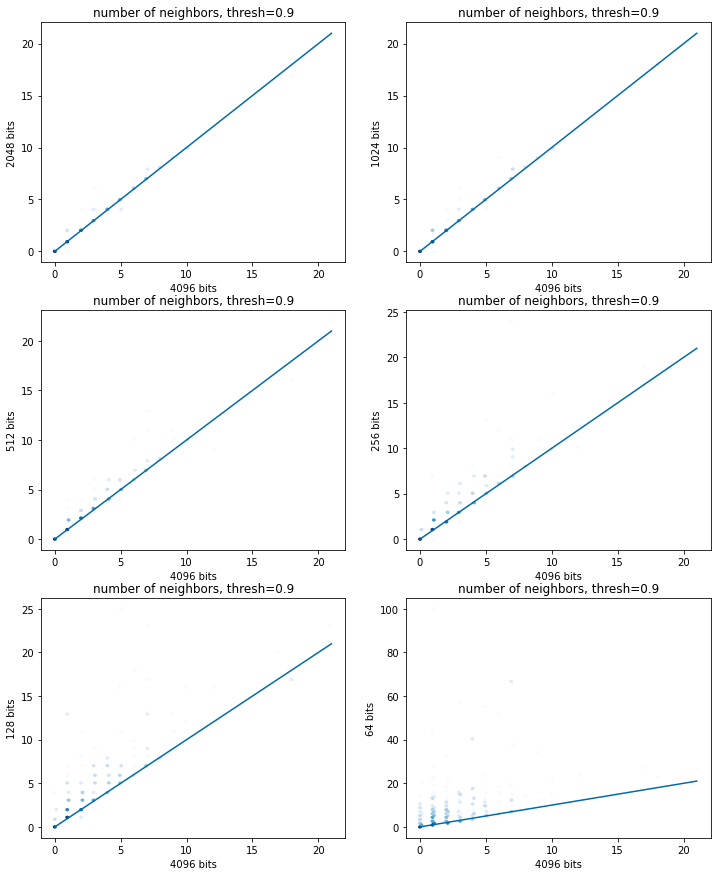

In [15]:
thresh = 0.9
bcounts = (2048,1024,512,256,128,64)

figsize(12,15)
for i,yv in enumerate(bcounts): 
    subplot(3,2,i+1)
    xv = 4096
    mv = max(results[xv][thresh])
    hexbin(results[xv][thresh],results[yv][thresh],bins='log',cmap='Blues')
    plot([0,mv],[0,mv]);
    xlabel(f'{xv} bits')
    ylabel(f'{yv} bits');
    title(f'number of neighbors, thresh={thresh:0.1f}');

Do the same thing with a threshold of 0.6

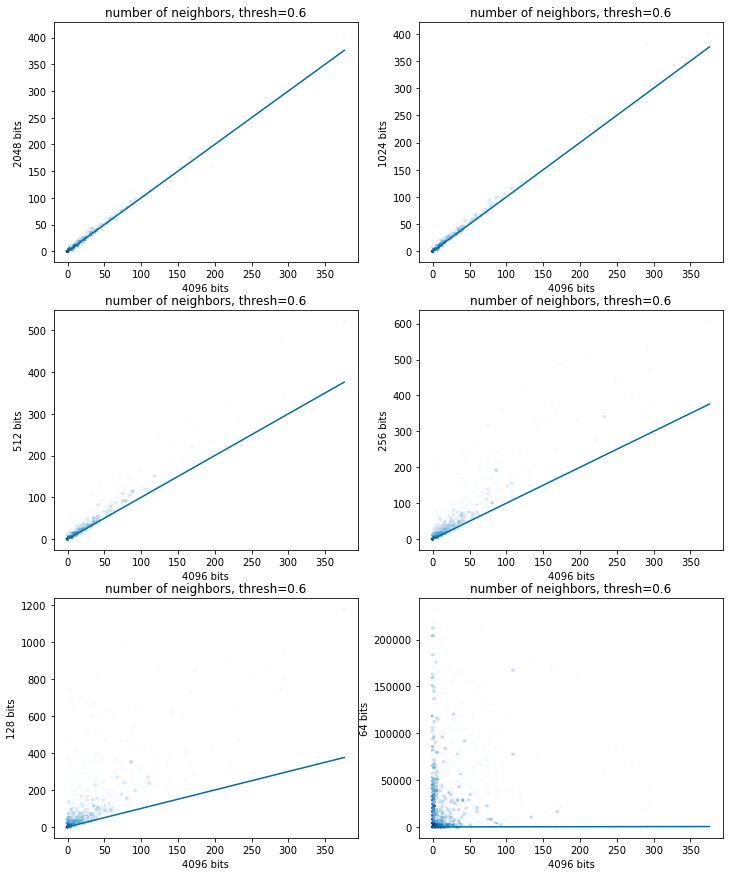

In [16]:
thresh = 0.6
bcounts = (2048,1024,512,256,128,64)

figsize(12,15)
for i,yv in enumerate(bcounts): 
    subplot(3,2,i+1)
    xv = 4096
    mv = max(results[xv][thresh])
    hexbin(results[xv][thresh],results[yv][thresh],bins='log',cmap='Blues')
    plot([0,mv],[0,mv]);
    xlabel(f'{xv} bits')
    ylabel(f'{yv} bits');
    title(f'number of neighbors, thresh={thresh:0.1f}');

We can see here that the more folded fingerprints tend to yield more neighors at a given threshold. This makes sense given what we saw above, which is that similarity values tend to be higher as fingerprints are folded.

It's also clear, though not super surprising, that the 64 bit fingerprint isn't going to be useful with low similarity thresholds: we just get way too many extra hits.

## How many hits do we miss?

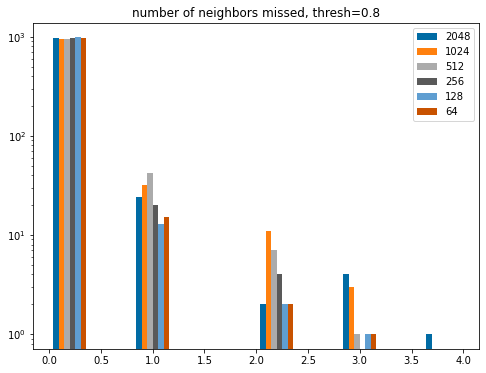

In [19]:
figsize(8,6)
thresh = 0.8
bcounts = (2048,1024,512,256,128,64)
hist([missed[x][0.8] for x in bcounts],log='true', label=[str(x) for x in bcounts]);
legend();
title(f'number of neighbors missed, thresh={thresh:.1f}');

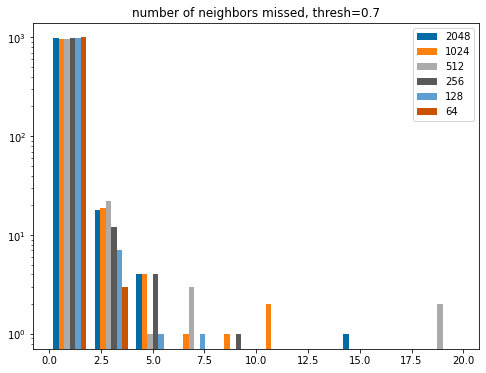

In [20]:
thresh = 0.7
bcounts = (2048,1024,512,256,128,64)
hist([missed[x][thresh] for x in bcounts],log='true', label=[str(x) for x in bcounts]);
legend();
title(f'number of neighbors missed, thresh={thresh:.1f}');

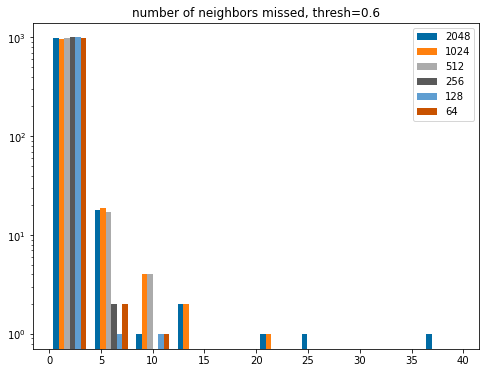

In [21]:
figsize(8,6)

thresh = 0.6
bcounts = (2048,1024,512,256,128,64)
hist([missed[x][thresh] for x in bcounts],log='true', label=[str(x) for x in bcounts]);
legend();
title(f'number of neighbors missed, thresh={thresh:.1f}');

Look at result counts where hits were missed

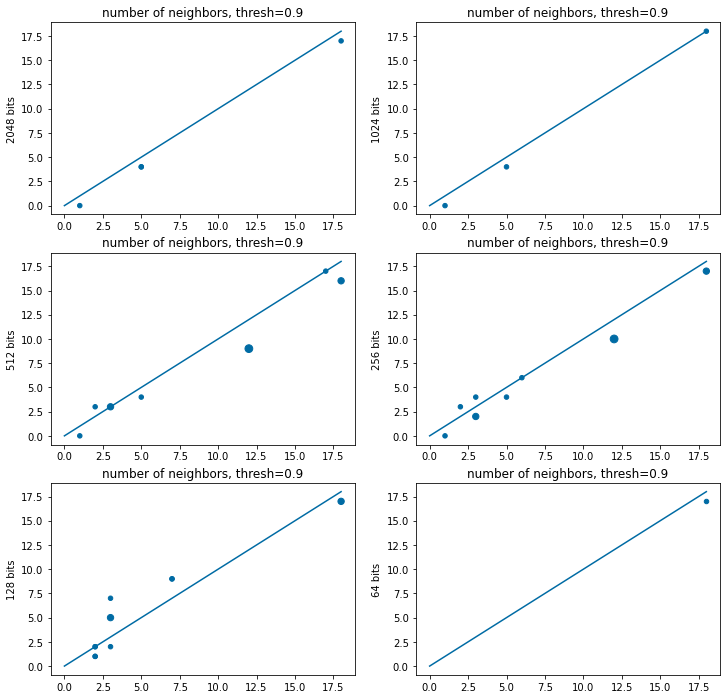

In [22]:
thresh = 0.9

figsize(12,12)
for i,yv in enumerate(bcounts): 
    subplot(3,2,i+1)
    xv = 4096
    tresx = [x for i,x in enumerate(results[xv][thresh]) if missed[yv][thresh][i]]
    tresy = [x for i,x in enumerate(results[yv][thresh]) if missed[yv][thresh][i]]
    tresr = [20*x for i,x in enumerate(missed[yv][thresh]) if x]
    mv = max(tresx)
    scatter(tresx,tresy,tresr)
    plot([0,mv],[0,mv]);
    #xlabel(f'{xv} bits')
    ylabel(f'{yv} bits');
    title(f'number of neighbors, thresh={thresh:.1f}');

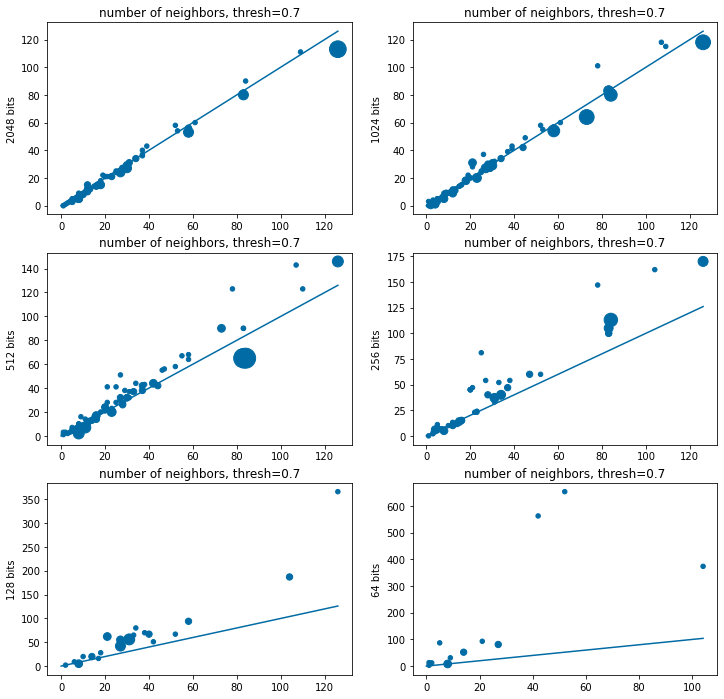

In [23]:
thresh = 0.7

figsize(12,12)
for i,yv in enumerate(bcounts): 
    subplot(3,2,i+1)
    xv = 4096
    tresx = [x for i,x in enumerate(results[xv][thresh]) if missed[yv][thresh][i]]
    tresy = [x for i,x in enumerate(results[yv][thresh]) if missed[yv][thresh][i]]
    tresr = [20*x for i,x in enumerate(missed[yv][thresh]) if x]
    mv = max(tresx)
    scatter(tresx,tresy,tresr)
    plot([0,mv],[0,mv]);
    #xlabel(f'{xv} bits')
    ylabel(f'{yv} bits');
    title(f'number of neighbors, thresh={thresh:.1f}');

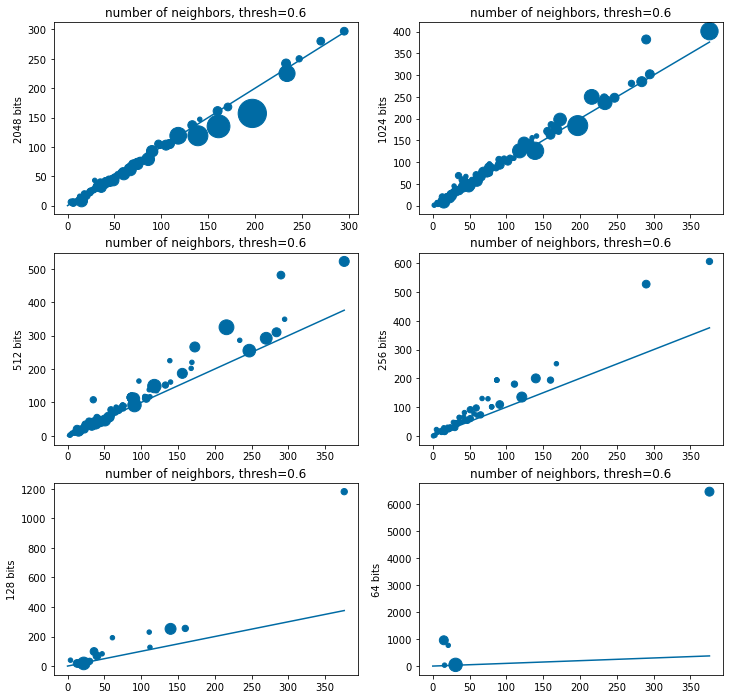

In [24]:
thresh = 0.6

figsize(12,12)
for i,yv in enumerate(bcounts): 
    subplot(3,2,i+1)
    xv = 4096
    tresx = [x for i,x in enumerate(results[xv][thresh]) if missed[yv][thresh][i]]
    tresy = [x for i,x in enumerate(results[yv][thresh]) if missed[yv][thresh][i]]
    tresr = [20*x for i,x in enumerate(missed[yv][thresh]) if x]
    mv = max(tresx)
    sc = scatter(tresx,tresy,tresr)
    plot([0,mv],[0,mv]);
    #xlabel(f'{xv} bits')
    ylabel(f'{yv} bits');
    title(f'number of neighbors, thresh={thresh:.1f}');

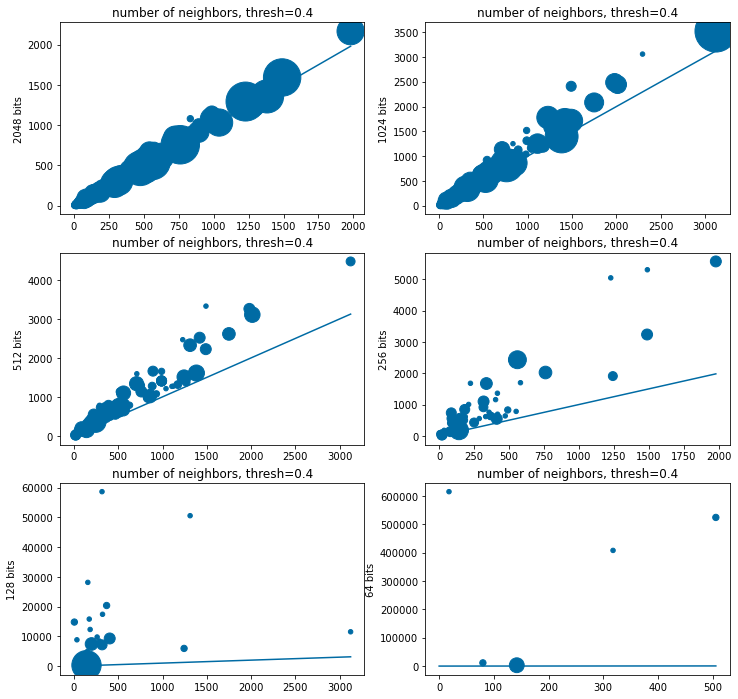

In [25]:
thresh = 0.4

figsize(12,12)
for i,yv in enumerate(bcounts): 
    subplot(3,2,i+1)
    xv = 4096
    tresx = [x for i,x in enumerate(results[xv][thresh]) if missed[yv][thresh][i]]
    tresy = [x for i,x in enumerate(results[yv][thresh]) if missed[yv][thresh][i]]
    tresr = [20*x for i,x in enumerate(missed[yv][thresh]) if x]
    mv = max(tresx)
    sc = scatter(tresx,tresy,tresr)
    plot([0,mv],[0,mv]);
    #xlabel(f'{xv} bits')
    ylabel(f'{yv} bits');
    title(f'number of neighbors, thresh={thresh:.1f}');

## Efficiency, look at the number of extra hits

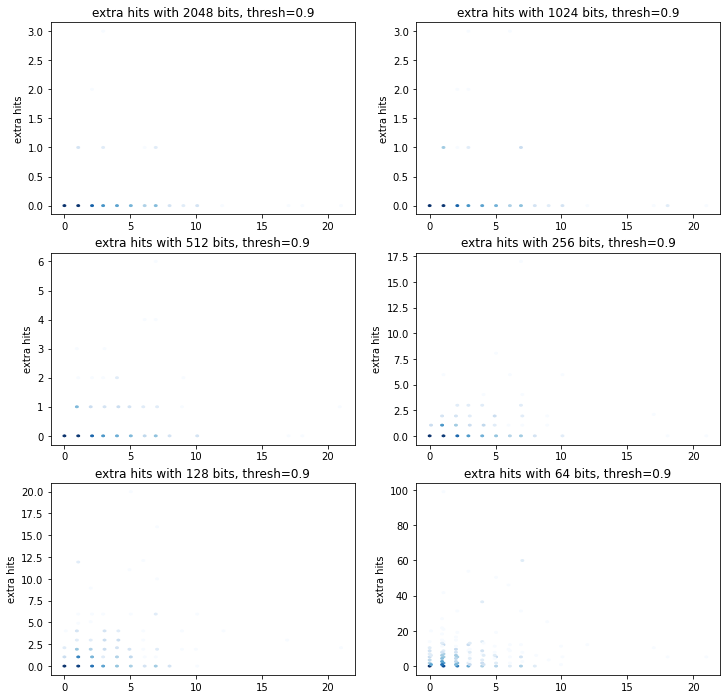

In [26]:
thresh = 0.9

figsize(12,12)
for i,yv in enumerate(bcounts): 
    subplot(3,2,i+1)
    xv = 4096
    delt = [x-results[xv][thresh][i] for i,x in enumerate(results[yv][thresh])]
    tresx = [x for i,x in enumerate(results[xv][thresh]) if delt[i]>=0]
    tresy = [x for i,x in enumerate(delt) if x>=0]
    mv = max(tresx)
    hexbin(tresx,tresy,bins='log',cmap='Blues')
    ylabel(f'extra hits');
    title(f'extra hits with {yv} bits, thresh={thresh:.1f}');

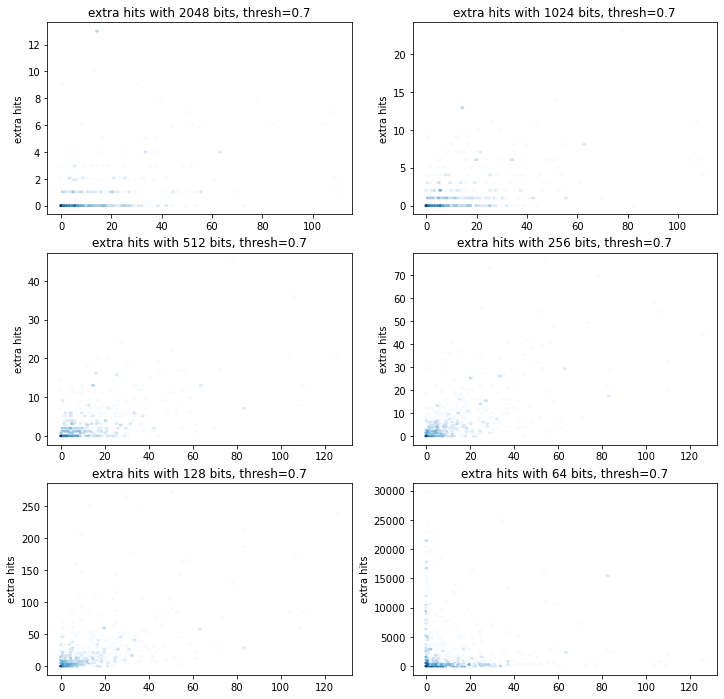

In [27]:
thresh = 0.7

figsize(12,12)
for i,yv in enumerate(bcounts): 
    subplot(3,2,i+1)
    xv = 4096
    delt = [x-results[xv][thresh][i] for i,x in enumerate(results[yv][thresh])]
    tresx = [x for i,x in enumerate(results[xv][thresh]) if delt[i]>=0]
    tresy = [x for i,x in enumerate(delt) if x>=0]
    mv = max(tresx)
    hexbin(tresx,tresy,bins='log',cmap='Blues')
    ylabel(f'extra hits');
    title(f'extra hits with {yv} bits, thresh={thresh:.1f}');

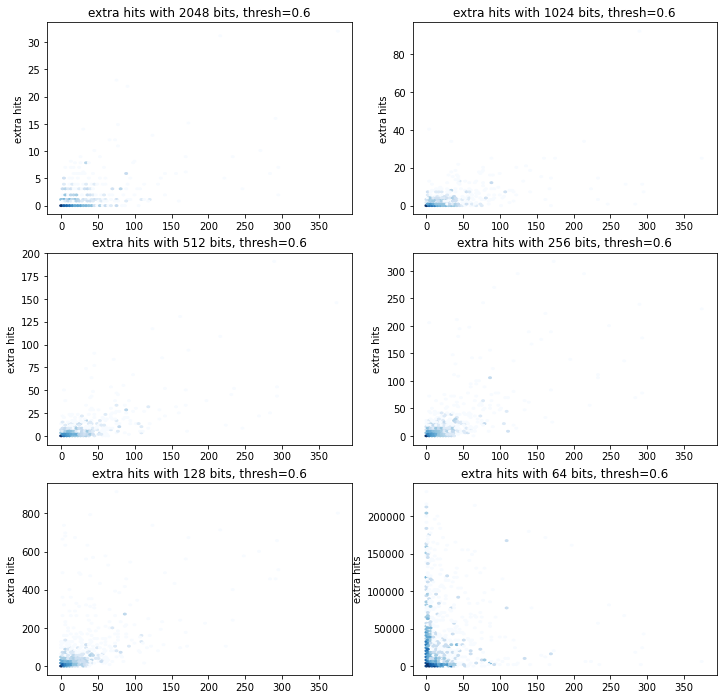

In [28]:
thresh = 0.6

figsize(12,12)
for i,yv in enumerate(bcounts): 
    subplot(3,2,i+1)
    xv = 4096
    delt = [x-results[xv][thresh][i] for i,x in enumerate(results[yv][thresh])]
    tresx = [x for i,x in enumerate(results[xv][thresh]) if delt[i]>=0]
    tresy = [x for i,x in enumerate(delt) if x>=0]
    mv = max(tresx)
    hexbin(tresx,tresy,bins='log',cmap='Blues')
    ylabel(f'extra hits');
    title(f'extra hits with {yv} bits, thresh={thresh:.1f}');

This makes it even more obvious that the 64bit fingerprints are just too short. 128 bits seems to be a good balance.